# Part I: Jupiter Simulations
__Created By:__ Tayt Armitage <br>
__Edited By:__ Bailey Stephens, Ethan Fahimi <br>
__Creation Date:__ 2/1/2022

In [1]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import math as math
import astropy.constants as ac
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.io.ascii 

In [2]:
# Increases resolution of plots
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

## First, read in the file and make a data frame.

Use the pandas package to read the file. 

In [3]:
#Reads in file of exoplanet data
pdat = pd.read_csv('PS_2022.01.25_13.10.22.csv', comment='#')
# Show dataframe 
pdat.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
2,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-09-04,2017-03,2018-09-06
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603,2018-09-04,2017-03,2018-09-06


# Next, split data frame into seperate data frames based on detection method.

In [4]:
#Creates a data frame of just the planets discovered by radial velocity
radv = pdat[pdat["discoverymethod"] == "Radial Velocity"]

#Creates a data frame of just the planets discovered by direct imaging
img = pdat[pdat["discoverymethod"] == "Imaging"]

#Creates a data frame of just the planets discovered by Transit
transit = pdat[pdat["discoverymethod"] == "Transit"]

#Creates a data frame of just the planets discovered by Astrometry
astro = pdat[pdat["discoverymethod"] == "Astrometry"]

#Creates a data frame of just the planets discovered by Microlensing
lens = pdat[pdat["discoverymethod"] == "Microlensing"]

# Important Solar System Data

Gathering relevant data to include planets from our solar system in the graphs to be made below. This data was collected from  [NASA's Planetary Fact Sheet](https://nssdc.gsfc.nasa.gov/planetary/factsheet/planet_table_ratio.html). This fact sheet did not include the semi-major axes of the planets in the solar system, those values were obtained [here](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes#Semi-major_and_semi-minor_axes_of_the_planets'_orbits). 

In [5]:
#Creates a data frame with solar system data from
#https://nssdc.gsfc.nasa.gov/planetary/factsheet/planet_table_ratio.html
    
Mass = {'Mass':[0.0553,0.815,1,0.107,317.8,95.2,14.5,17.1]}
SolSys= pd.DataFrame(Mass)
#Adds column for radii
SolSys['RadE'] = [0.383,0.949,1,0.532,11.21,9.45,4.01,3.88]
#Adds column for Period
SolSys['Per'] = [88.0,224.7,365.2,687.0,4331,10747,30589,59800]
#Adds column for semimajor axis
SolSys['SemiMaj'] = [0.387,0.723,1.000,1.524,5.204,9.582,19.218,30.110]
#Add shapes for plotting
#https://matplotlib.org/stable/api/markers_api.html
SolSys['Shap'] = ['X','*','$\oplus$','>','v','+','d','P']
#Add colors for plotting
SolSys['Col'] = ['Black','Black','Black','Black','Black','Black','Black','Black']
#Add names of planets
SolSys['Name'] = ['Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']

# Define the state of the art equations for each detection method, beginning with radial velocity detection.

The "radial velocity signal" $K$ is given by
   
$$ K = \left( \frac{M_\text{exo}}{M_\star} \right) \sqrt{\frac{G M_\star}{a}} \sin{i}$$
 
This equation can be rearranged to solve for the mass of the planet as a function of the mass of its parent star and semi-major axis. 
We assume $K = 0.5$, and G is the gravitational constant $G = 6.67 \cdot 10^{-11} m^{3}Kg^{-1}s^{-2}$. We also assume a sin(i) =1. 

In [6]:
#Defines a function to compute mass of a planet given the mass of the parent star and semimajor axis

def massplanet(Ms,a):
    """
    Takes in 2 values:
        The mass of the star
        The semimajor axis of the planet
    
    Computes the mass of the planet in units of kg
    
    Returns the mass of the planet in earth masses
    """
    
    K = 0.5               #K in m/s, definition from state of the art detection methods
    G = 6.67 * 10**(-11)  #Defines Gravitational constant G
    
    #Converts the mass of star into kg
    Mstar = Ms * (1.989 * 10**(30))
    
    #Converts the semi-major axis from au to m
    am = a * 1.496* 10**(11)
   
    #Calculates the mass of the planet
    mp = K * Mstar * (am/(G*Mstar))**(1/2)
    
    #Converts planet mass to Earth Masses
    Mp = mp * 1/(5.972* 10**(24))
    
    return Mp

Now, with this function above defined we can compute a range of masses of planets located at similiar semi-major axes to those in our data set. This predictive model will serve as the detection limit for radial velocity detections utilizing state of the art techniques.

In [7]:
# Computes a range of masses, periods, and semi major axis using state of the art methods
a_arr = 10.0**(np.arange(5)-2) * u.AU
mp_a = massplanet(1,a_arr)

Additionally, to better display this limit we can utilize Kepler's Law to compute a range of reasonable periods for these planets as well.

In [8]:
# Computes the relationship for period and semi-major axis
rv_p = (a_arr)**(3/2) * 365 

# State of the art equations for direct imaging detection




In this section we define many of the equations necessary to put limits on the process of direct imaging, which involves directly photographing a planet as it orbits its host star. A few assumptions have been made to optimize this process. First the detection wavelength to be used is $\lambda = 22.3 \mu m$. This is the peak emission wavelength of a blackbody similar to Jupiter. Additionally we wil be using a telescope diameter of 10.4 $\mu m$, based around the Gran Telescopio Canarias. With these and the equation 

$\theta \approx 1.22 \frac{\lambda}{D}$
                                   
We can calculate the separation of the star and the planet.


In [9]:
#Assume peak emission wavelength of a blackbody
lam = 22.3e-6 * u.m

#Defines the width of our telescope
D = 10.4 *u.m

#Computes theta using state of the art methods
theta = 1.22*lam/D

Then with this data we can use $\theta = \frac{a}{d}$ to calculate the miminum semi-major axis a planet can be detected at under these limits. To further accuracy we will use the closest star in our data set, as this will set a reasonable assumption  

In [10]:

#Computes detection limit of semimajor axis in direct imaging
a_lim = (theta*img['sy_dist'].min())*206265

print(a_lim)

5.874097937593847


Now for this part we can calculate the limit radius. This can be done assuming a few values, these being a planet star contrast of $f = 10^{-7}$, a sun like star, and a Jupiter analogue with a temperature of T = 130K. With these numbers in mind we can then use this formula to calculate our limiting radius for direct imaging.

$f = \left( \frac{R_{p}}{R_\star} \right)^2 \cdot \frac{{\text{exp}\left[\frac{hc}{\lambda k_{B}T_{\star}}\right]} - 1}{\text{exp}\left[\frac{hc}{\lambda k_{B}T_\text{exo}}\right] - 1}$

In [11]:
#Defines our state of the art detection for star planet contrast
f = 1e-7

#Defines the assumptions of star and planet temperature
Tstar = 5772 * u.K
Texo = 130*u.K

#Defines assumption of sun like star
R_DI_Star = 1 *u.Rsun

#Defines necessary constants
h = 6.62607015e-34*((u.kg*u.m**2*u.s**-2)*u.s) # Planck's constant
c = 299792458*(u.m/u.s) # speed of light
k_B = 1.380649e-23*((u.m**2)*(u.kg)/(u.s**2)/(u.K)) # Boltzmann constant

#Computes our detection limit radius
R_exo_img = (R_DI_Star* np.sqrt(f*((np.exp((h*c)/(lam*k_B*Texo))-1))/(np.exp((h*c)/(lam*k_B*Tstar))-1))).decompose().to(u.Rearth)

#Defines lines to plot limits
Rlimx = [a_lim,a_lim]
Rlimy = [R_exo_img/u.Rearth,10**3]

alimx =[a_lim,10**5]
alimy =[R_exo_img/u.Rearth,R_exo_img/u.Rearth]

print(R_exo_img)

1.195310533145422 earthRad


# State of the art equations for Transit Methods

Here we assume the signal to noise ratio, snr = 7.1, sigma is 30 parts per million. We also assume a 90 day data collection period. We also assume that the planet is orbiting a sun-like star. Finally, we assume the inclination is 90 degrees. With these assumpitions in place we can then use these equations to calculate a series of radii to serve as our detection limit for the transit method.

\begin{align}
n_{tr} &= \frac{90 days}{P} \\\\
t_{dur} &= 3.91 hr * (\frac{P}{10 day})^{\frac{1}{3}} \\\\
SNR &= (\frac{R_{exo}}{R_{star}})^{2} \sqrt{\frac{n_{tr} * t_{dur}}{3 hr}}
\end{align}

In [12]:
# Define start-of the art assumptions
SNR = 7.1
sigma = 30e-6

#Defines an array of plausible periods in days
P_arr = 10.0**(np.arange(9)-1) * u.day

#Defines number of transits
ntr = 90 * u.day / P_arr

#Defines transit duration
t_dur = 3.91* u.hr *(P_arr/(10*u.day))**(1/3)

#Defines assumed star radius
R_t_star = 1 * u.Rsun

In [13]:
#Computes state of the art radius limits
R_trns = R_t_star * np.sqrt(sigma * SNR / np.sqrt((ntr*t_dur)/(3*u.hr)))

All of our limits have thus been computed, so the next step is to plot various graphs with our detection limits over plotted onto the graphs in which they shine the most. Additionally solar system data will be plotted as a reference.

# Plots Mass vs Period of exoplanets

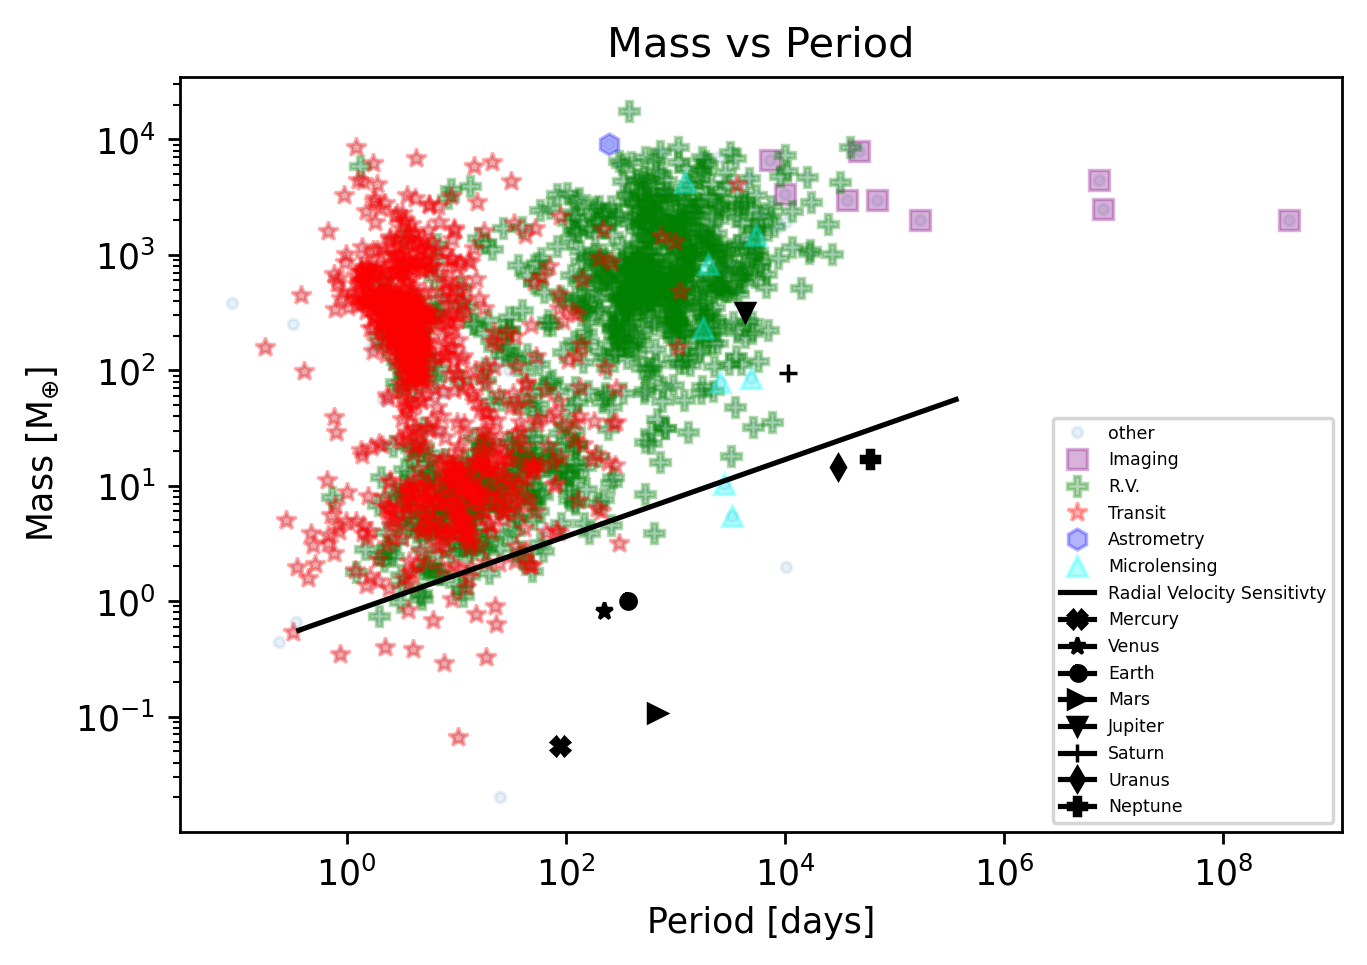

In [14]:
#Plots mass vs period
fig,ax = plt.subplots()
ax.loglog(pdat["pl_orbper"], pdat["pl_bmasse"], ".", alpha = 0.1, label = "other")
ax.loglog(img["pl_orbper"], img["pl_bmasse"], 's', alpha = 0.3, label = 'Imaging', color = "purple")
ax.loglog(radv["pl_orbper"], radv["pl_bmasse"], "P", alpha = 0.3, label= "R.V.", color = 'green')
ax.loglog(transit["pl_orbper"], transit["pl_bmasse"], "*",alpha = 0.3, label = "Transit", color = 'red')
ax.loglog(astro["pl_orbper"], astro["pl_bmasse"], "h",alpha = 0.3, label ="Astrometry", color ='blue' )
ax.loglog(lens["pl_orbper"], lens["pl_bmasse"], "^", alpha = 0.3, label = "Microlensing", color = "cyan")
ax.set_xlabel("Period [days]")
ax.set_ylabel(r"Mass [M$_{\oplus}$]")
ax.set_title("Mass vs Period")

#Overplots radial velocity sensitivity
ax.plot(rv_p,mp_a,color = 'black', label = "Radial Velocity Sensitivty")

# add all the solar system planets
for i in range(len(SolSys['Mass'])):
    ax.loglog(SolSys['Per'][i],SolSys['Mass'][i], marker = SolSys['Shap'][i],color = SolSys['Col'][i],label = SolSys['Name'][i],markersize = 5)

plt.legend(prop = {'size' : 5})
plt.show()

# Plot Mass vs Semi-major axis of exoplanets and radial velocity detection limit along with above graph

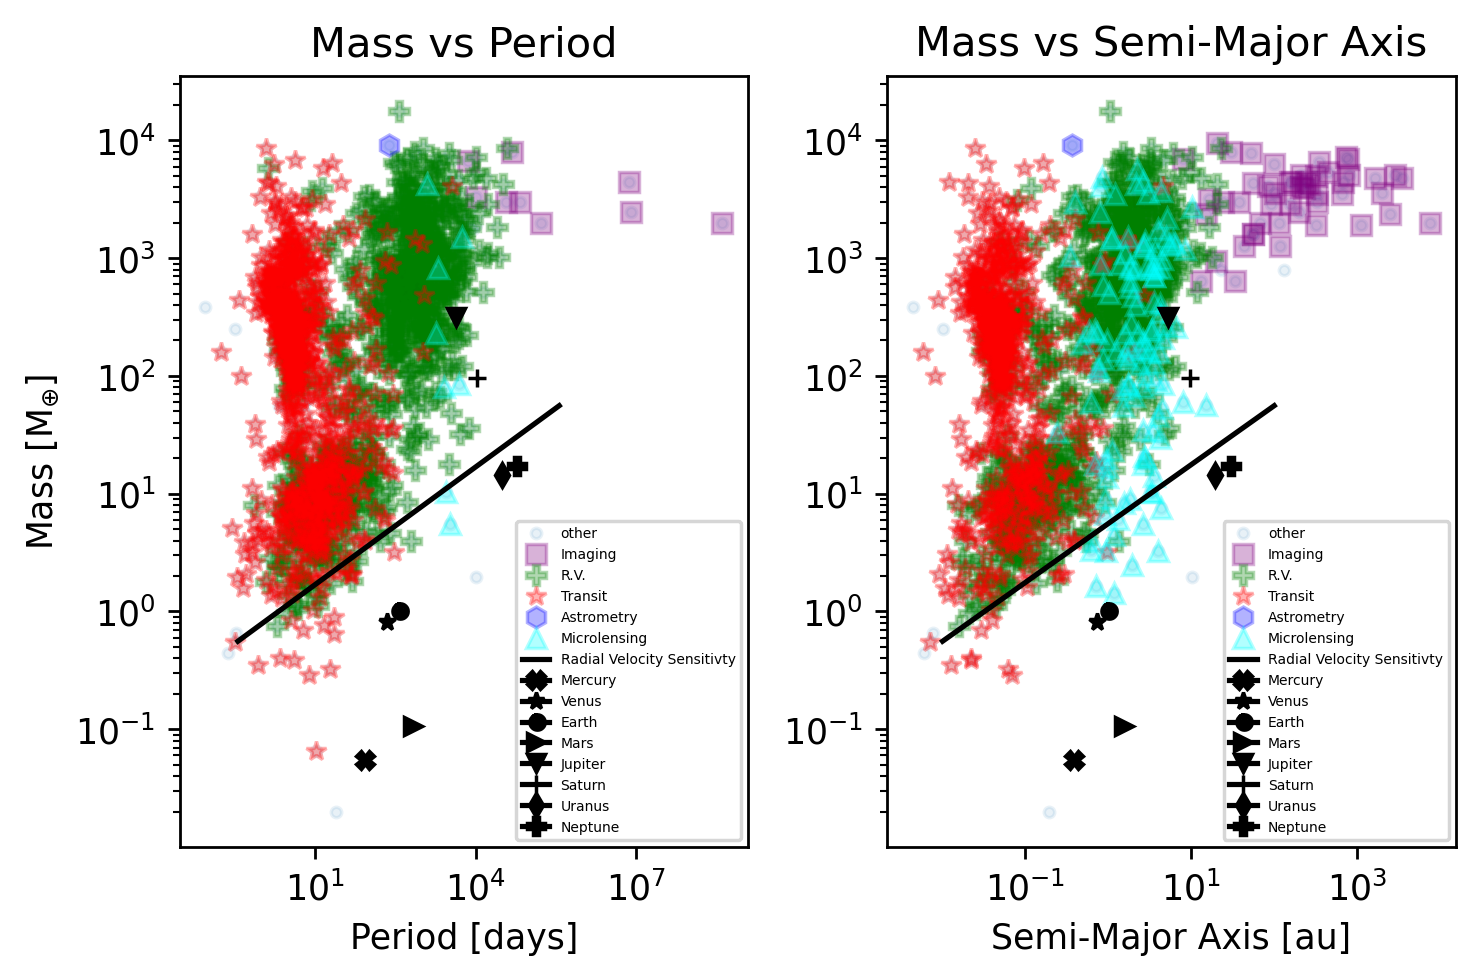

In [15]:
#Plots mass vs period
fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.loglog(pdat["pl_orbper"], pdat["pl_bmasse"], ".", alpha = 0.1, label = "other")
ax1.loglog(img["pl_orbper"], img["pl_bmasse"], 's', alpha = 0.3, label = 'Imaging', color = "purple")
ax1.loglog(radv["pl_orbper"], radv["pl_bmasse"], "P", alpha = 0.3, label= "R.V.", color = 'green')
ax1.loglog(transit["pl_orbper"], transit["pl_bmasse"], "*",alpha = 0.3, label = "Transit", color = 'red')
ax1.loglog(astro["pl_orbper"], astro["pl_bmasse"], "h",alpha = 0.3, label ="Astrometry", color ='blue' )
ax1.loglog(lens["pl_orbper"], lens["pl_bmasse"], "^", alpha = 0.3, label = "Microlensing", color = "cyan")
ax1.set_xlabel("Period [days]")
ax1.set_ylabel(r"Mass [M$_{\oplus}$]")
ax1.set_title("Mass vs Period")

#Overplots radial velocity sensitivity
ax1.plot(rv_p,mp_a,color = 'black', label = "Radial Velocity Sensitivty")

# add all the solar system planets
for i in range(len(SolSys['Mass'])):
    ax1.loglog(SolSys['Per'][i],SolSys['Mass'][i], marker = SolSys['Shap'][i],color = SolSys['Col'][i],label = SolSys['Name'][i],markersize = 5)

ax1.legend(prop ={'size' : 4 })
    
#Plots mass vs semi-major axis
ax2.loglog(pdat["pl_orbsmax"], pdat["pl_bmasse"], ".", alpha = 0.1, label = "other")
ax2.loglog(img["pl_orbsmax"], img["pl_bmasse"], 's', alpha = 0.3, label = 'Imaging', color = "purple")
ax2.loglog(radv["pl_orbsmax"], radv["pl_bmasse"], "P", alpha = 0.3, label= "R.V.", color = 'green')
ax2.loglog(transit["pl_orbsmax"], transit["pl_bmasse"], "*",alpha = 0.3, label = "Transit", color = 'red')
ax2.loglog(astro["pl_orbsmax"], astro["pl_bmasse"], "h",alpha = 0.3, label ="Astrometry", color ='blue' )
ax2.loglog(lens["pl_orbsmax"], lens["pl_bmasse"], "^", alpha = 0.3, label = "Microlensing", color = "cyan")
ax2.set_xlabel("Semi-Major Axis [au]")
ax2.set_title("Mass vs Semi-Major Axis")

#Overplots radial velocity sensitivity
ax2.plot(a_arr.value,mp_a,color = 'black', label = "Radial Velocity Sensitivty")

# add all the solar system planets
for i in range(len(SolSys['Mass'])):
    ax2.loglog(SolSys['SemiMaj'][i],SolSys['Mass'][i], marker = SolSys['Shap'][i],color = SolSys['Col'][i],label = SolSys['Name'][i],markersize = 5)

ax2.legend(prop ={'size' : 4})
fig.tight_layout(pad=1.0)
plt.savefig('RV_plots.png', bbox_inches='tight')


# Plots radius vs period and detection limit for transits

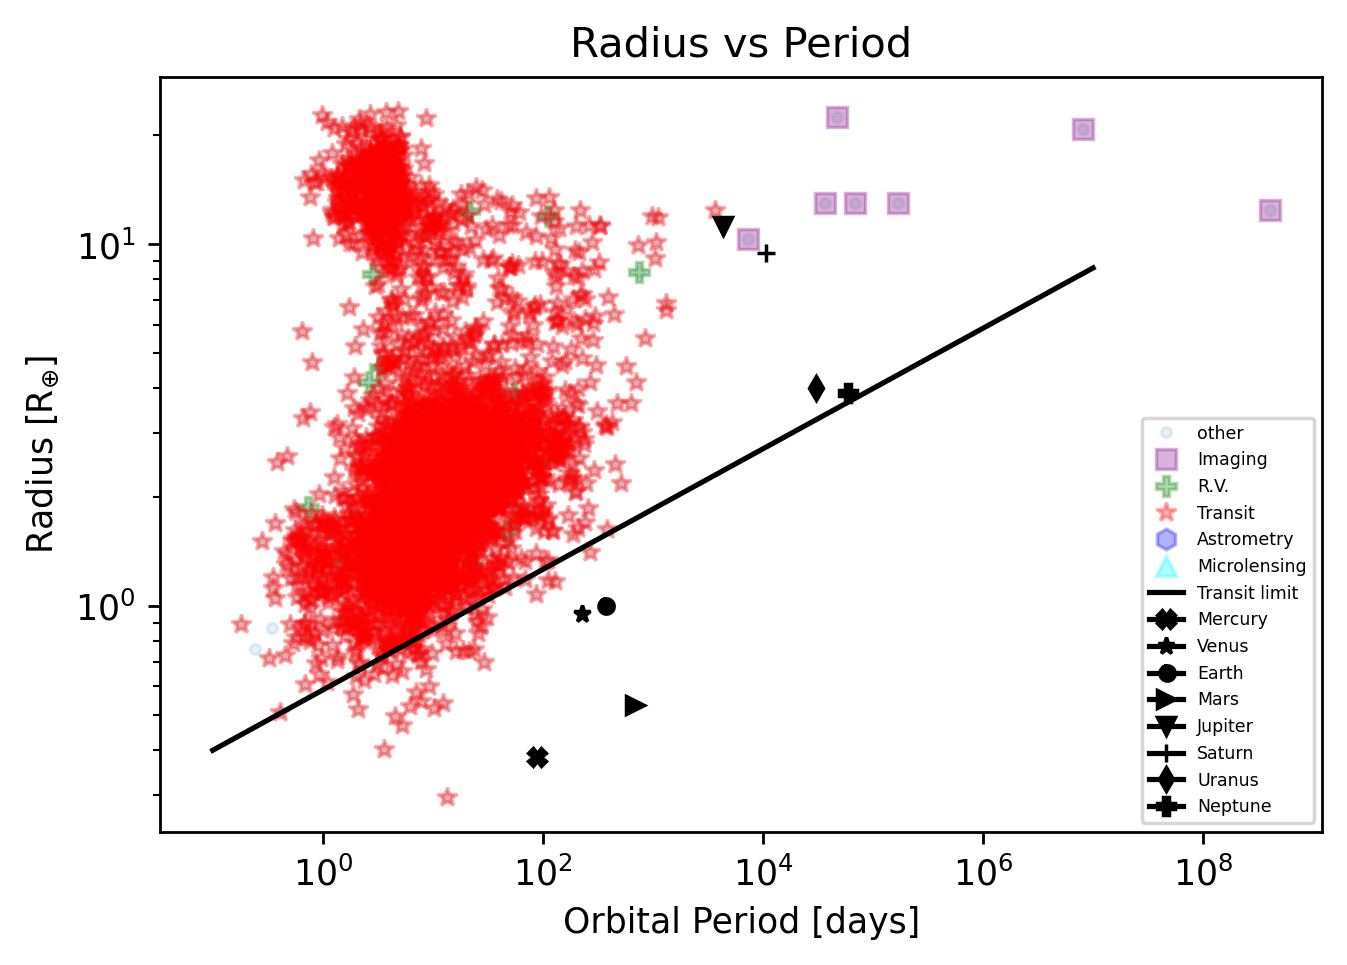

In [16]:
#Plots radius vs period
fig,ax2 = plt.subplots()
ax2.loglog(pdat["pl_orbper"], pdat["pl_rade"], ".", alpha = 0.1, label = "other")
ax2.loglog(img["pl_orbper"], img["pl_rade"], 's', alpha = 0.3, label = 'Imaging', color = "purple")
ax2.loglog(radv["pl_orbper"], radv["pl_rade"], "P", alpha = 0.3, label= "R.V.", color = 'green')
ax2.loglog(transit["pl_orbper"], transit["pl_rade"], "*",alpha = 0.3, label = "Transit", color = 'red')
ax2.loglog(astro["pl_orbper"], astro["pl_rade"], "h",alpha = 0.3, label ="Astrometry", color ='blue' )
ax2.loglog(lens["pl_orbper"], lens["pl_rade"], "^", alpha = 0.3, label = "Microlensing", color = "cyan")
ax2.loglog(P_arr.value,R_trns.decompose().to(u.Rearth),color = 'black', label = "Transit limit")
ax2.set_xlabel("Orbital Period [days]")
ax2.set_ylabel(r"Radius [R$_{\oplus}$]")
ax2.set_title("Radius vs Period")

# add all the solar system planets
for i in range(len(SolSys['RadE'])):
    ax2.loglog(SolSys['Per'][i],SolSys['RadE'][i], marker = SolSys['Shap'][i],color = SolSys['Col'][i],label = SolSys['Name'][i],markersize = 5)

plt.legend(prop = {'size':5})
plt.savefig('Period_vs_Exo_Radius.png', bbox_inches='tight')
plt.show()

# Plots radius vs semi-major axis and detection limit of direct imaging

5.795074198523076
1.2285863161770587 earthRad


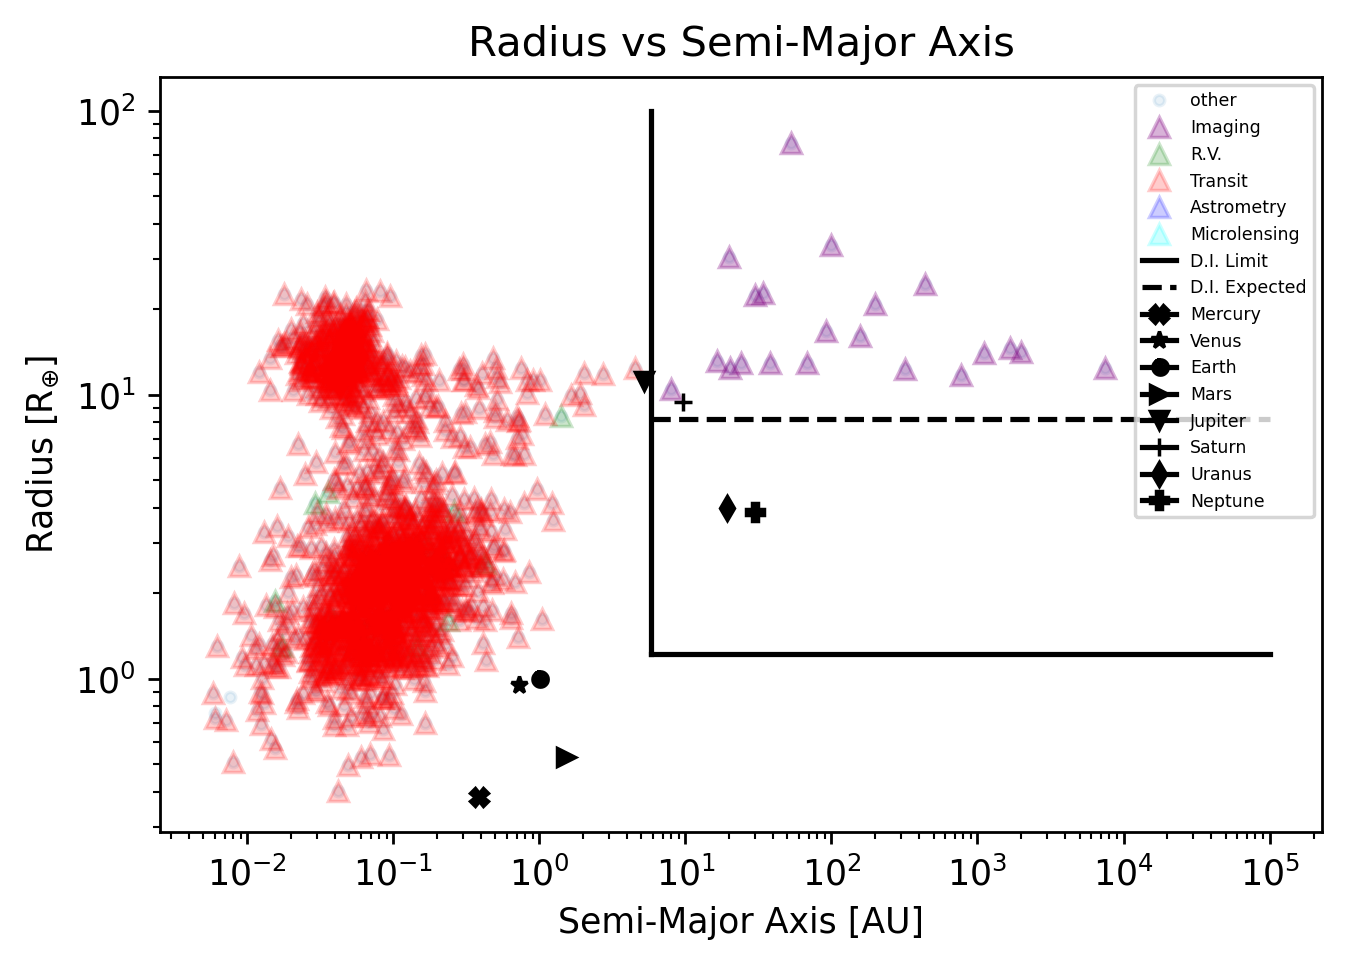

In [17]:
#Assume peak emission wavelength of a blackbody
lam = 22e-6 * u.m

#Defines the width of our telescope
D = 10.4 *u.m

#Computes theta using state of the art methods
theta = 1.22*lam/D

#Computes detection limit of semimajor axis in direct imaging
a_lim = (theta*img['sy_dist'].min())*206265

print(a_lim)

#Defines our state of the art detection for star planet contrast
f = 1e-7

#Defines the assumptions of star and planet temperature
Tstar = 5778 * u.K
Texo = 130*u.K

#Defines assumption of sun like star
R_DI_Star = 1 *u.Rsun

#Defines necessary constants
h = 6.62607015e-34*((u.kg*u.m**2*u.s**-2)*u.s) # Planck's constant
c = 299792458*(u.m/u.s) # speed of light
k_B = 1.380649e-23*((u.m**2)*(u.kg)/(u.s**2)/(u.K)) # Boltzmann constant

#Computes our detection limit radius
R_img = (R_DI_Star* np.sqrt(f*((np.exp((h*c)/(lam*k_B*Texo))-1))/(np.exp((h*c)/(lam*k_B*Tstar))-1))).decompose().to(u.Rearth)

#Defines lines to plot limits
Rlimx = [a_lim,a_lim]
Rlimy = [R_img/u.Rearth,10**2]

alimx_dotted = [a_lim,10**5]
alimy_dotted = [R_img/u.Rearth + 7,R_img/u.Rearth + 7]

alimx =[a_lim,10**5]
alimy =[R_img/u.Rearth,R_img/u.Rearth]

#HMMMM THIS IS A FUNKY RESULT ASSUMPTION MAY BE WRONG MORE RESEARCH NECESSARY
print(R_img)


#Plots radius vs semi-major axis
fig,ax3 = plt.subplots()
ax3.loglog(pdat["pl_orbsmax"], pdat["pl_rade"], ".", alpha = 0.1, label = "other")
ax3.loglog(img["pl_orbsmax"], img["pl_rade"], '^', alpha = 0.3, label = 'Imaging', color = "purple")
ax3.loglog(radv["pl_orbsmax"], radv["pl_rade"], "^", alpha = 0.2, label= "R.V.", color = 'green')
ax3.loglog(transit["pl_orbsmax"], transit["pl_rade"], "^",alpha = 0.2, label = "Transit", color = 'red')
ax3.loglog(astro["pl_orbsmax"], astro["pl_rade"], "^",alpha = 0.2, label ="Astrometry", color ='blue' )
ax3.loglog(lens["pl_orbsmax"], lens["pl_rade"], "^", alpha = 0.2, label = "Microlensing", color = "cyan")
ax3.loglog(Rlimx,Rlimy, color = 'black', label = 'D.I. Limit')
ax3.loglog(alimx,alimy, color = 'black')
ax3.loglog(alimx_dotted,alimy_dotted, '--', color = 'black', label = 'D.I. Expected')
ax3.set_xlabel("Semi-Major Axis [AU]")
ax3.set_ylabel(r"Radius [R$_{\oplus}$]")
ax3.set_title("Radius vs Semi-Major Axis")

# add all the solar system planets
for i in range(len(SolSys['Mass'])):
    ax3.loglog(SolSys['SemiMaj'][i],SolSys['RadE'][i], marker = SolSys['Shap'][i],color = SolSys['Col'][i],label = SolSys['Name'][i],markersize = 5)

plt.legend(prop = {'size':5})
plt.savefig('Radius_vs_Semimajor_Axis.png', bbox_inches='tight')
plt.show()